In [1]:
import os
import h5py
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import numpy as np
from iminuit import minuit
from iminuit.cost import LeastSquares

In [2]:
parent = r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IRdetection\Test_data\data_20_02_set1'

In [3]:
def reader(parent):

    data = {
        "res1" : [],
        "res2" : [],
        "res3" : [],
        "res4" : []
    }

    for folder in os.listdir(parent):
        if folder.startswith("T"):
            T = folder.replace('T_','')
            for file in os.listdir(parent + '/' + folder):
                dic = {
                    'F' : [],
                    'I' : [],
                    'Q' : [],
                    'S21' : []
                }
                with h5py.File(parent + '/' + folder + '/' + file, 'r') as f:
                    dic['F'] = np.array(f['raw_data']['f'][:])
                    dic['I'] = np.array(f['raw_data']['i'][:])
                    dic['Q'] = np.array(f['raw_data']['q'][:])
                    dic['S21'] = 20*np.log(np.sqrt(dic['I']**2 + dic['Q']**2))
                    dic['Phi'] = np.unwrap(np.arctan2(dic['I'],dic['Q']))
                    if '1' in file:
                        data['res1'].append([T, dic])
                    elif '2' in file:
                        data['res2'].append([T, dic])
                    elif '3' in file:
                        data['res3'].append([T, dic])
                    elif '4' in file:
                        data['res4'].append([T, dic])
    
    return data 

In [4]:
def resonance_model(x,a, Q, Qc,phi0):
    return -a*np.abs(1-Q/Qc*np.exp(1j*phi0)/(1+1j*((2*x*Q))))

def model(x, a0, a1, a2, Q, Qc,phi0):
    params = np.array([a0,a1,a2])
    pol = np.polyval(params, x)
    res = resonance_model(x, a0, Q,Qc,phi0)
    return res*pol

In [5]:
data = reader(parent)

In [6]:
F, T, S21, Phi, I, Q = [], [], [], [],[], []
   
for i,datas in enumerate(data['res2']):
    T.append(int(datas[0]))
    S21.append(datas[1]['S21'])
    F.append(datas[1]['F'])
    Phi.append(datas[1]['Phi'])

In [7]:
with open('FAverzani.txt', 'w') as f:
    for i in range(len(S21[0])):
        f.writelines(str(F[0][i])+'\t'+str(S21[0][i])+'\t'+str(Phi[0][i])+'\n')

In [8]:
sorted_indices = sorted(range(len(T)), key=lambda k: T[k])
T   = [np.array(T[i]) for i in sorted_indices]
S21 = [np.array(S21[i]) for i in sorted_indices]
Phi = [np.array(Phi[i]) for i in sorted_indices]
F   = [np.array(F[i]) for i in sorted_indices]

Center data around resonance minimum

In [9]:
a = []
for i in range(len(T)):
    a.append(np.polyfit(F[i],Phi[i],1))
    Phi[i] = Phi[i] - np.polyval(a[i],F[i])
    #F[i] = (F[i]-F[i][np.argmin(S21[i])])/F[i][np.argmin(S21[i])]
    #F[i] = F[i][(np.argmin(S21[i])-400):(np.argmin(S21[i])+400)]
    #Phi[i] = Phi[i][(np.argmin(S21[i])-400):(np.argmin(S21[i])+400)]
    #S21[i] = S21[i][(np.argmin(S21[i])-400):(np.argmin(S21[i])+400)]

In [10]:
def phase(nu, Q, Qc,phi0, nu0):
    x = (nu-nu0)/nu0
    num = (1-(Q/Qc)*np.exp(-1j*phi0)/(1+1j*(2*x*Q))).imag
    den = (1-(Q/Qc)*np.exp(-1j*phi0)/(1+1j*(2*x*Q))).real
    return np.unwrap(np.arctan(num/den))

def mod(x, Q, Qc,phi0):
    return -50*np.abs(1-(Q/Qc)*np.exp(-1j*phi0)/(1+1j*(2*x*Q)))

def model(nu, a, b, c, Q, Qc,phi0,nu0):
    x = (nu-nu0)/nu0
    return (a*x**2+b*x+c)*np.abs(1-(Q/Qc)*np.exp(-1j*phi0)/(1+1j*(2*x*Q)))

In [27]:
params = []
params2 = [-100000,-1000,-50,8500,9000,-3,5.577*1e9]

In [28]:
m, m_mod, lsq, lsq_mod, popt, pcov = [], [], [], [],[], []
for i in range(len(T)):
    lsq_mod.append(LeastSquares(F[i],S21[i],1,model))
    m_mod.append(minuit.Minuit(lsq_mod[i],*params2))
    m_mod[i].limits['Q'] = (0,2e4)
    m_mod[i].limits['Qc'] = (0,2e4)
    m_mod[i].migrad()

In [29]:
for i in range(len(T)):
    params.append([m_mod[i].values[3],m_mod[i].values[4],m_mod[i].values[5],m_mod[i].values[6]])
    lsq.append(LeastSquares(F[i],Phi[i],0.01,phase))
    m.append(minuit.Minuit(lsq[i],*params[i]))
    m[i].migrad()

In [30]:
m_mod[0].params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,-21.4e3,3.0e3,,,,,
1,b,-143,8,,,,,
2,c,-49.78,0.04,,,,,
3,Q,8.59e3,0.15e3,,,0,2E+04,
4,Qc,13.09e3,0.17e3,,,0,2E+04,
5,phi0,-3.251,0.013,,,,,
6,nu0,5.576380e9,0.000005e9,,,,,


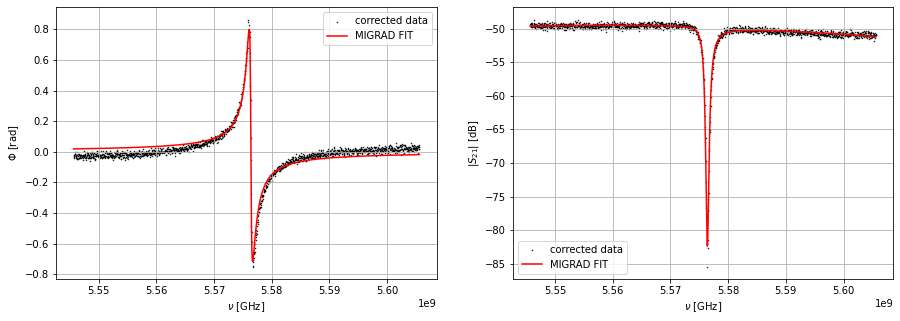

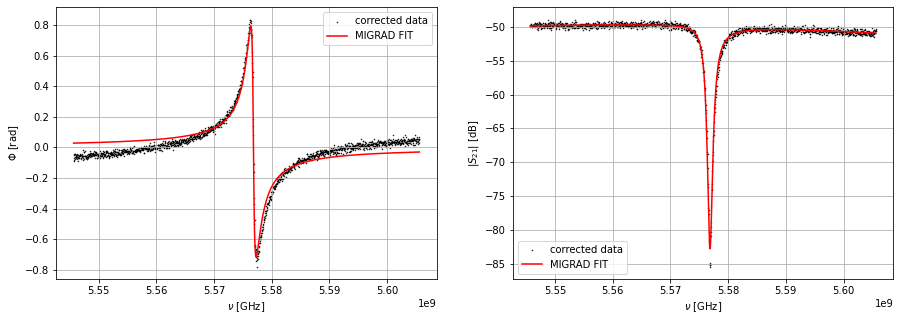

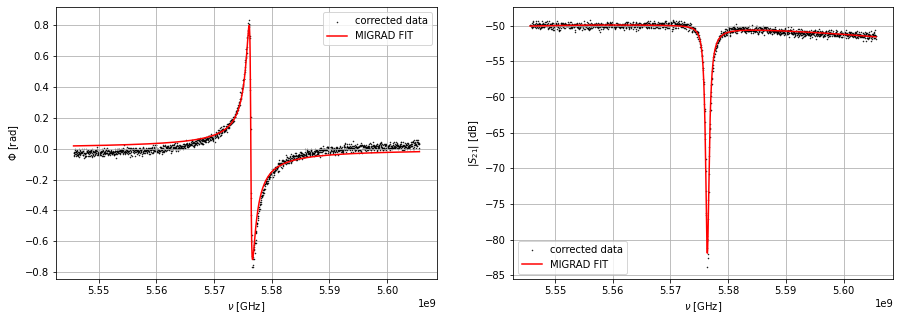

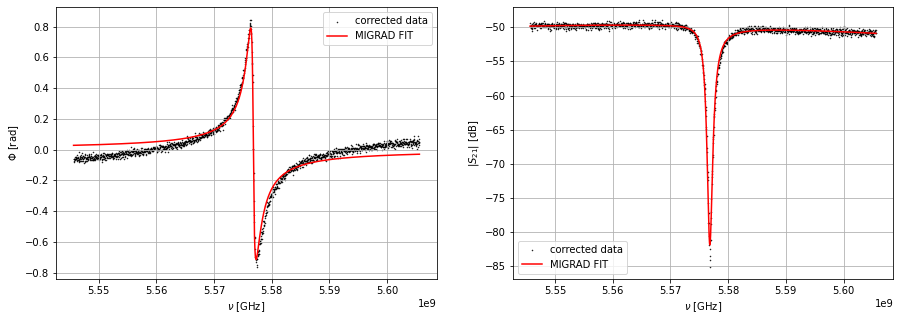

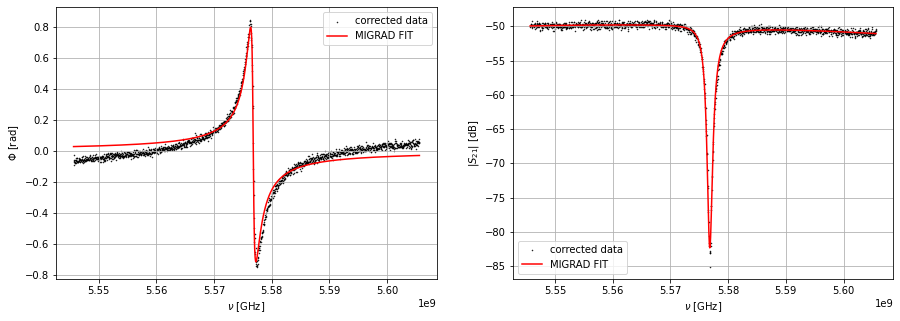

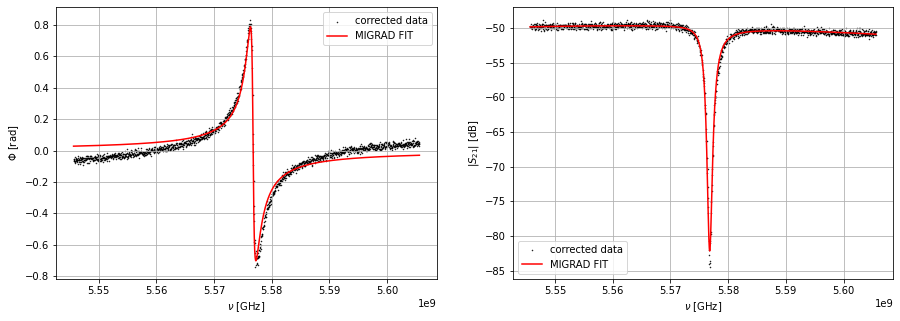

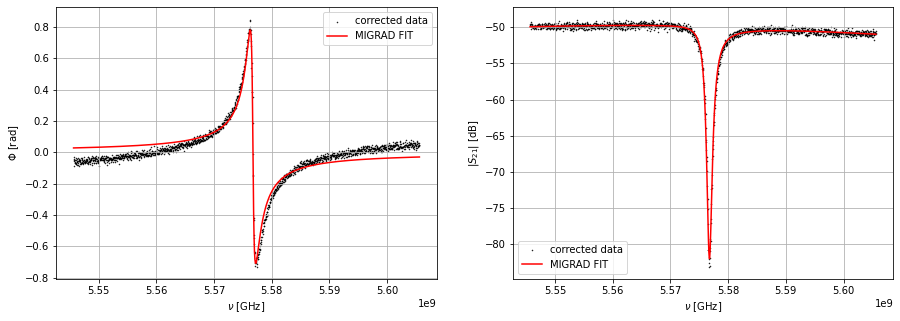

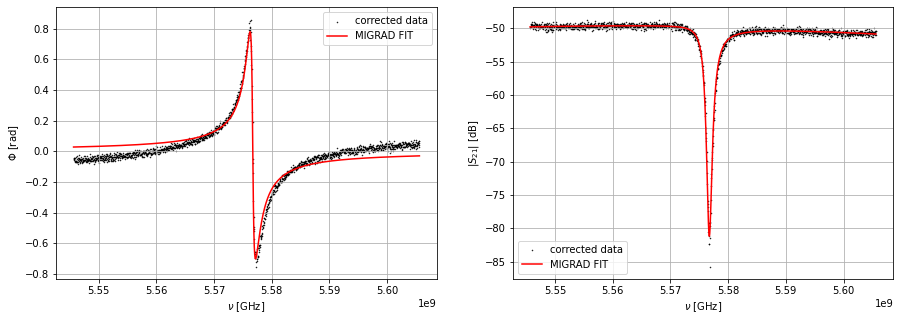

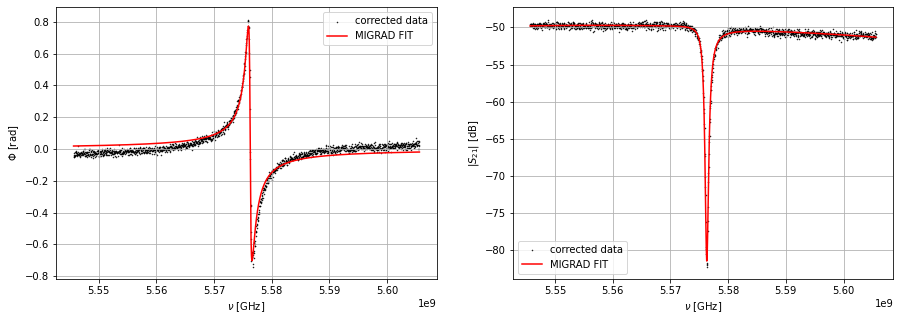

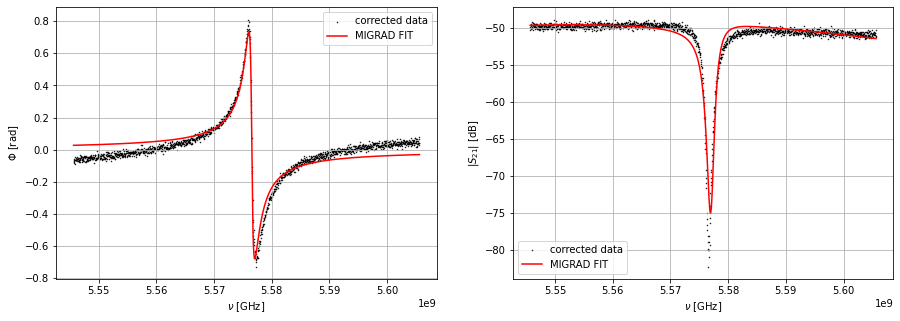

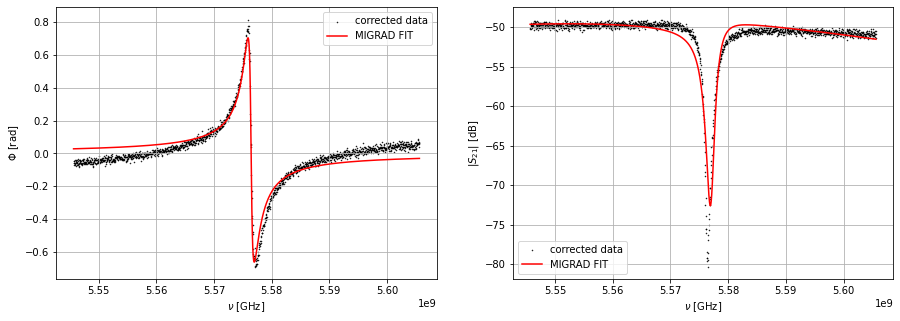

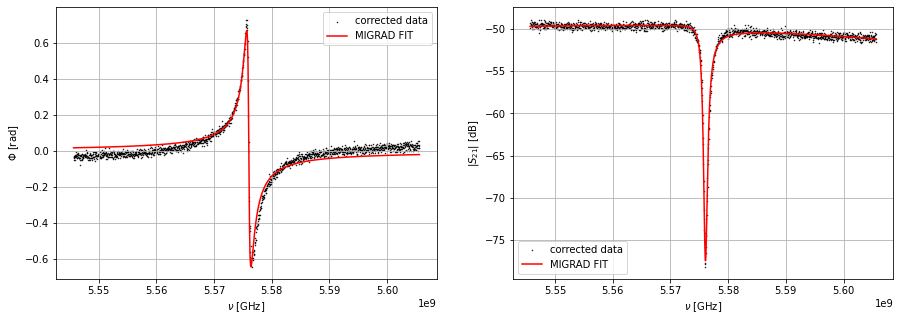

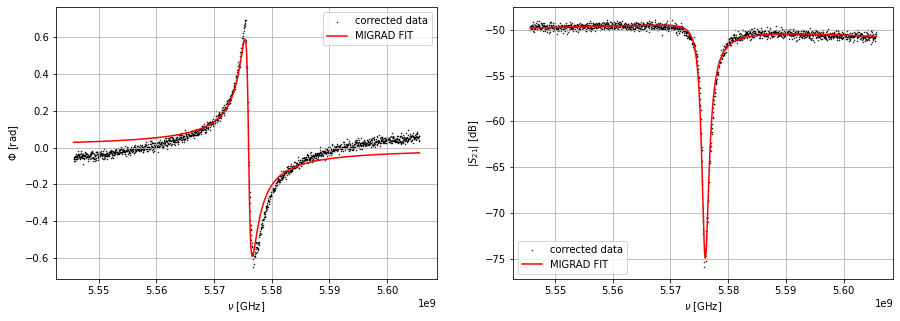

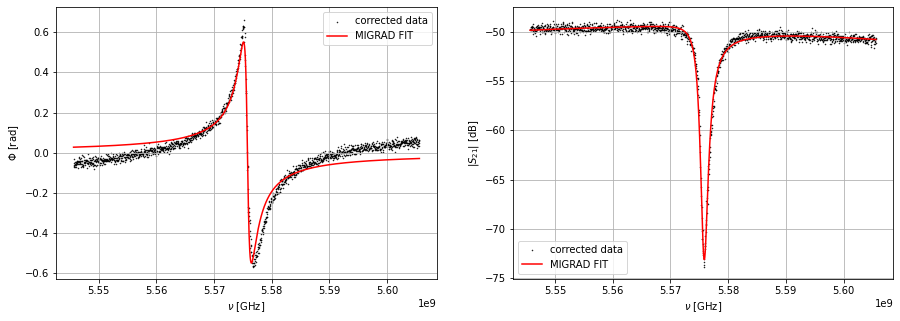

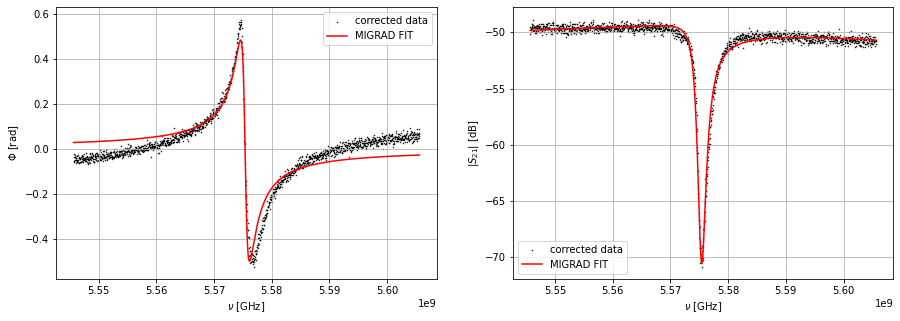

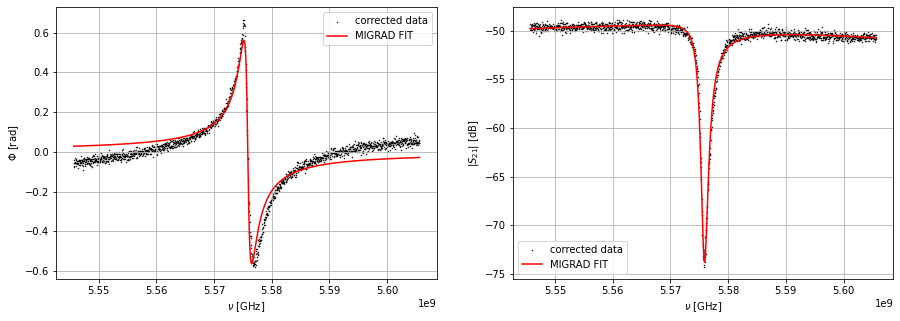

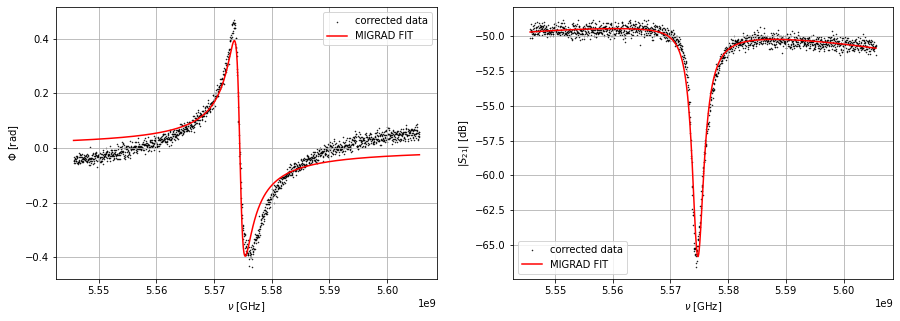

In [31]:
for i,t in enumerate(T):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].scatter(F[i],Phi[i],label='corrected data',color='black',marker='.',s=1)
    axs[0].set_xlabel(r'$\nu$ [GHz]')
    axs[0].set_ylabel(r'$\Phi$ [rad]')
    axs[0].plot(F[i],phase(F[i],*m[i].values),label='MIGRAD FIT',color='red')
    axs[0].legend()
    axs[0].grid()

    '''box_props = dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='bisque')
    text_box_content = (r'$Q$ = '+f'{m[i].values[0]:.2f}'+r' $\pm$ '+f'{m[i].errors[0]:.2f}\n' +
                        r'$Q_{c}$ = '+f'{m[i].values[1]:.2f}'+r' $\pm$ '+f'{m[i].errors[1]:.2f}\n' +
                        r'$\phi_{0}$ = '+f'{m[i].values[2]:.2f}'+r' $\pm$ '+f'{m[i].errors[2]:.2f}\n'+
                        r'$\chi^{2}_{0}$ = '+ f'{(m[i].fval/m[i].ndof):.2f}\n'+
                        r'$Q_{i} = \frac{Q_{c}Q}{Q_{c}-Q} = $'+f'{m[i].values[0]*m[i].values[1]/(m[i].values[1]-m[i].values[0]):.2f}')
    text_box = plt.text(-0.006, -101, text_box_content, fontsize=12, color='black', bbox=box_props)'''

    axs[1].scatter(F[i],S21[i],label='corrected data',color='black',marker='.',s=1)
    axs[1].set_xlabel(r'$\nu$ [GHz]')
    axs[1].set_ylabel(r'$|S_{21}|$ [dB]')
    axs[1].plot(F[i],model(F[i],*m_mod[i].values),label='MIGRAD FIT',color='red')
    axs[1].legend()
    axs[1].grid()
    

    '''box_props = dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='bisque')
    text_box_content = (
                        r'$a$ = '+f'{m_mod[i].values[0]:.2f}'+r' $\pm$ '+f'{m_mod[i].errors[0]:.2f}\n' +
                        r'$b$ = '+f'{m_mod[i].values[1]:.2f}'+r' $\pm$ '+f'{m_mod[i].errors[1]:.2f}\n' +
                        r'$c$ = '+f'{m_mod[i].values[2]:.2f}'+r' $\pm$ '+f'{m_mod[i].errors[2]:.2f}\n' +
                        r'$Q$ = '+f'{m_mod[i].values[3]:.2f}'+r' $\pm$ '+f'{m_mod[i].errors[3]:.2f}\n' +
                        r'$Q_{c}$ = '+f'{m_mod[i].values[4]:.2f}'+r' $\pm$ '+f'{m_mod[i].errors[4]:.2f}\n' +
                        r'$\phi_{0}$ = '+f'{m_mod[i].values[5]:.2f}'+r' $\pm$ '+f'{m_mod[i].errors[5]:.2f}\n'+
                        r'$\chi^{2}_{0}$ = '+ f'{(m_mod[i].fval/m_mod[i].ndof):.2f}\n'
                        r'$Q_{i} = \frac{Q_{c}Q}{Q_{c}-Q} = $'+f'{m_mod[i].values[4]*m_mod[i].values[3]/(m_mod[i].values[4]-m_mod[i].values[3]):.2f}')
    #text_box = plt.text(0.0002, -101, text_box_content, fontsize=12, color='black', bbox=box_props)'''

In [32]:
print(m_mod[0].params)

┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  -21.4e3  │   3.0e3   │            │            │         │         │       │
│ 1 │ b    │   -143    │     8     │            │            │         │         │       │
│ 2 │ c    │  -49.78   │   0.04    │            │            │         │         │       │
│ 3 │ Q    │  8.59e3   │  0.15e3   │            │            │    0    │  20000  │       │
│ 4 │ Qc   │  13.09e3  │  0.17e3   │            │            │    0    │  20000  │       │
│ 5 │ phi0 │  -3.251   │   0.013   │            │            │         │         │       │
│ 6 │ nu0  │5.576380e9 │0.000005e9 │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [33]:
y, yerr,y_mod, yerr_mod = [], [],[],[]
with open('Results_Phase.txt', 'w') as file:
    file.write('T\tQ\tsigma_Q\tQc\tsigma_Qc\tQi\tsigma_Qi\n')
    for i, obj in enumerate(m):
        T_val = int(T[i])
        Q_val = float(m[i].values[0])
        sigma_Q_val = float(m[i].errors[0])
        Qc_val = float(m[i].values[1])
        sigma_Qc_val = float(m[i].errors[1])
        Qi_val = 1/m[i].values[0]-1/m[i].values[1]
        y.append(Qi_val)
        sigma_Qi_val = m[i].errors[0]/(m[i].values[0]**2)+m[i].errors[1]/(m[i].values[1]**2) 
        yerr.append(sigma_Qi_val)
        file.write(f'{T_val}\t{Q_val}\t{sigma_Q_val}\t{Qc_val}\t{sigma_Qc_val}\t{Qi_val}\t{sigma_Qc_val}\n')

with open('Results_S21.txt', 'w') as file:
    file.write('T\tQ\tsigma_Q\tQc\tsigma_Qc\tQi\tsigma_Qi\n')
    for i, obj in enumerate(m):
        T_val = int(T[i])
        Q_val = float(m_mod[i].values[3])
        sigma_Q_val = float(m_mod[i].errors[3])
        Qc_val = float(m_mod[i].values[4])
        sigma_Qc_val = float(m_mod[i].errors[4])
        Qi_val = 1/m_mod[i].values[3]-1/m_mod[i].values[4]
        y_mod.append(Qi_val)
        sigma_Qi_val = m_mod[i].errors[3]/(m_mod[i].values[3]**2)+m_mod[i].errors[4]/(m_mod[i].values[4]**2) 
        yerr_mod.append(sigma_Qi_val)
        file.write(f'{T_val}\t{Q_val}\t{sigma_Q_val}\t{Qc_val}\t{sigma_Qc_val}\t{Qi_val}\t{sigma_Qc_val}\n')


In [34]:
from scipy import constants as cnst
T = np.array(T)*1e-3

In [35]:
sigma = np.std(np.array(y_mod[0:3]))
alpha = 0.8669
d0 = 1.69*1e-23
hbar = cnst.Planck
KB = cnst.Boltzmann
b = 0
T_k = 0.15
q0 = y_mod[0]
p = [q0, d0]

In [36]:
from scipy import special as sp

def kondo(T,q0, d0):
    omega = 5*1e9
    csi = (hbar * omega)/(2*KB*T)
    num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
    den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
    return num/den * (alpha/2) + q0

C:\Users\kid\AppData\Local\Temp\ipykernel_9132\965735641.py:6: RuntimeWarning: overflow encountered in sinh
  num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
C:\Users\kid\AppData\Local\Temp\ipykernel_9132\965735641.py:6: RuntimeWarning: invalid value encountered in multiply
  num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
C:\Users\kid\AppData\Local\Temp\ipykernel_9132\965735641.py:7: RuntimeWarning: invalid value encountered in multiply
  den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))


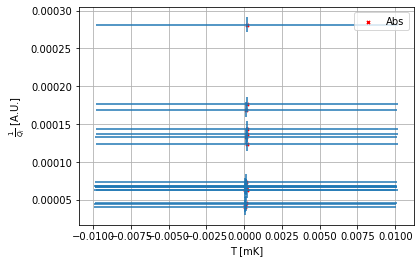

In [37]:
#plt.scatter(T,y,s=10,color='blue',marker='x',label='Phase')
plt.scatter(T,y_mod,s=10,color='red',marker='x',label='Abs')
plt.errorbar(T,y_mod,sigma*np.ones_like(y_mod),0.01*np.ones_like(y_mod),linestyle='')
plt.plot(T,kondo(T, *p))
plt.ylabel(r'$\frac{1}{Q_{i}}$ [A.U.]')
plt.xlabel('T [mK]')
plt.legend()
plt.grid()

In [38]:
from scipy.optimize import curve_fit
err = np.sqrt((sigma*np.ones_like(y_mod))**2+(0.01*np.ones_like(y_mod))**2)
LSQ = (LeastSquares(T,y_mod,err,kondo))
mom = (minuit.Minuit(LSQ,*p))
mom.migrad()
popt, pcov = curve_fit(kondo, T, y_mod, [p[0], p[1]])

C:\Users\kid\AppData\Local\Temp\ipykernel_9132\965735641.py:6: RuntimeWarning: overflow encountered in sinh
  num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
C:\Users\kid\AppData\Local\Temp\ipykernel_9132\965735641.py:6: RuntimeWarning: invalid value encountered in multiply
  num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
C:\Users\kid\AppData\Local\Temp\ipykernel_9132\965735641.py:7: RuntimeWarning: invalid value encountered in multiply
  den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))


C:\Users\kid\AppData\Local\Temp\ipykernel_9132\965735641.py:6: RuntimeWarning: overflow encountered in sinh
  num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
C:\Users\kid\AppData\Local\Temp\ipykernel_9132\965735641.py:6: RuntimeWarning: invalid value encountered in multiply
  num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
C:\Users\kid\AppData\Local\Temp\ipykernel_9132\965735641.py:7: RuntimeWarning: invalid value encountered in multiply
  den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
C:\Users\kid\AppData\Local\Temp\ipykernel_9132\965735641.py:6: RuntimeWarning: overflow encountered in sinh
  num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
C:\Users\kid\AppData\Local\Temp\ipykernel_9132\965735641.py:6: RuntimeWarning: invalid value encountered in multiply
  num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
C:\Users\kid\AppData\Local\Temp\ipykernel_9132\965735641.py:7: RuntimeWarning: invalid value encountered in multiply
  den = np.pi*(1-2*np.exp(-d0/(KB*T))*

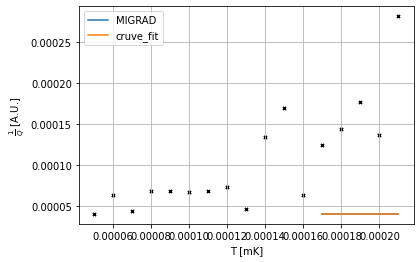

In [39]:
plt.scatter(T,y_mod,s=10,color='black',marker='x')
plt.plot(T,kondo(T, *mom.values),label='MIGRAD')
plt.plot(T,kondo(T, *popt), label='cruve_fit')
plt.ylabel(r'$\frac{1}{Q}$ [A.U.]')
plt.xlabel('T [mK]')
plt.grid()
plt.legend()

In [40]:
mom.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,q0,4.0025e-5,nan,,,,,
1,d0,1.69e-23,nan,,,,,


In [41]:
delta = 6.24*1e18*mom.values[1]

In [42]:
T_c = 4*mom.values[1]/(7*KB)
print('Delta               : '+str(delta*1e3)+' [meV]')
print('Critical temperature: '+str(T_c)+' [K]')

Delta               : 0.10545600000000001 [meV]
Critical temperature: 0.6994640098347122 [K]
